In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itk
import SimpleITK as sitk
from itkwidgets import view, compare, checkerboard

In [9]:
script_path = os.getcwd()
data_path = os.path.join(script_path, "data","elastix-test-data")
print(script_path)
print(data_path)

c:\Users\Yin\Desktop\Vrije_courses\internship\codes
c:\Users\Yin\Desktop\Vrije_courses\internship\codes\data\elastix-test-data


In [10]:
# get a list of all the patient IDs and set the mask path
patient_IDs = dict()
for file in os.listdir(data_path):
    if file.endswith(".nii.gz"):
        ID = file.split("_")[1]
        if ID not in patient_IDs:
            patient_IDs[ID] = 1
        else:
            patient_IDs[ID] += 1
    else:
        continue
print(patient_IDs)

{'004': 4, '006': 4, '011': 4, '012': 4, '020': 4, '025': 4, '026': 4, '034': 4, '039': 4, '050': 4, '051': 4, '055': 4, '058': 4, '067': 4, '069': 4, '073': 4, '074': 4, '092': 4, '106': 4, '109': 4, '110': 4, '112': 4, '113': 4, '114': 4, '125': 4, '176': 4, '177': 4, '180': 4, '181': 4, '186': 4, '187': 4, '190': 4, '282': 4, '291': 4, '299': 4, '315': 4}


In [11]:
# n = patient_IDs["106"]
# for i in range(n):
#     img_path = os.path.join(data_path, f"BLT_106_000{i}.nii.gz")
#     img = sitk.ReadImage(img_path)
#     print(f"image: BLT_106_000{i}.nii.gz, \nshape: {img.GetSize()}, \nspacing: {img.GetSpacing()}")

In [12]:
# def get_ref_info(ID, is_seg=False):
#     '''
#     Obtain the metadata of reference image.
    
#     Args:
#         ID: patient ID
#         is_seg: Set True if the file is segmentation (mask)
#     Returns:
#         A dictionary contains image shape, spacing, direction, origin, and pixel value.
#     '''
    
#     # a dictionary to store metadata
#     ref_info = dict()
    
#     ## Decide the reference image ##
#     # a list to store all image shapes
#     shape_list = list()
#     n = patient_IDs[ID]
#     if is_seg:
#         img_path = os.path.join(data_path, "mask", f"BLT_{ID}_0001.nii.gz")
#         img_shape = sitk.ReadImage(img_path).GetSize()
#         shape_list.append(img_shape)
#     else:
#         for i in range(n):
#             img_path = os.path.join(data_path, f"BLT_{ID}_000{i}.nii.gz")
#             img_shape = sitk.ReadImage(img_path).GetSize()
#             shape_list.append(img_shape)
#     # find the most common shape
#     ref_shape = Counter(shape_list).most_common(1)[0][0]
#     ref_index = shape_list.index(ref_shape)
#     ref_info["shape"] = ref_shape
#     # find the index of image
#     # ref_index = [key for key, value in shape_list.items() if value == ref_shape][0]
    
#     ref_path = os.path.join(data_path, f"BLT_{ID}_000{ref_index}.nii.gz")
#     ref_img = sitk.ReadImage(ref_path)
#     ref_info["spacing"] = ref_img.GetSpacing()
#     ref_info["direction"] = ref_img.GetDirection()
#     ref_info["origin"] = ref_img.GetOrigin()
#     ref_info["pixelvalue"] = ref_img.GetPixelIDValue()
#     return ref_info

In [13]:
def get_ref_info(ID, is_seg=False):
    '''
    Obtain the metadata of reference image.
    
    Args:
        ID: patient ID
        is_seg: Set True if the file is segmentation (mask)
    Returns:
        A dictionary contains image shape, spacing, direction, origin, and pixel value.
    '''
    
    # a dictionary to store metadata
    ref_info = dict()
    
    ## Decide the reference image ##
    # a list to store all image shapes
    n = patient_IDs[ID]
    if is_seg:
        ref_path = os.path.join(data_path, "mask", f"BLT_{ID}_0001.nii.gz")
    else:
        ref_path = os.path.join(data_path, f"BLT_{ID}_0001.nii.gz")
    
    ref_img = sitk.ReadImage(ref_path)
    
    ref_info["shape"] = ref_img.GetSize()
    ref_info["spacing"] = ref_img.GetSpacing()
    ref_info["direction"] = ref_img.GetDirection()
    ref_info["origin"] = ref_img.GetOrigin()
    ref_info["pixelvalue"] = ref_img.GetPixelIDValue()
    return ref_info

In [14]:
def resample_img(image, ref_info, is_seg=False):
    '''
    Implement the image resampling.
    
    Args:
        image: the targeted image
        ref_info: a dictionary contains image shape, spacing, direction, origin, and pixel value.
        is_seg: Set True if the file is segmentation (mask)
    Returns:
        Resampled image.
    '''

    resample = sitk.ResampleImageFilter()
    
    resample.SetSize(ref_info["shape"])
    resample.SetOutputSpacing(ref_info["spacing"])
    resample.SetOutputDirection(ref_info["direction"])
    resample.SetOutputOrigin(ref_info["origin"])
    resample.SetDefaultPixelValue(ref_info["pixelvalue"])
    resample.SetTransform(sitk.Transform())

    if is_seg:
        print("Resampling for the segmentation")
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        print("Resampling for the image")
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)

In [15]:
def create_4Dimage_array(ID, is_seg=False):
    '''
    Update the created image arrary with the loaded image data

    Args:
        ID: Patient ID
        is_seg: Set True if the file is segmentation (mask)
    Returns:
        A 4D numpy array contains 4 images or 4 duplicated segmentations.
    '''
    n_channel = patient_IDs[ID]
    ref_info = get_ref_info(ID, is_seg)
    ref_shape = ref_info["shape"]
    ref_spacing = ref_info["spacing"]
    x, y, z = ref_shape[2], ref_shape[1], ref_shape[0]
    combined_img = np.zeros([n_channel, x, y, z], np.float32)

    for i in range(n_channel):
        if is_seg:
            # only has one segmentation, duplicate each mask to 4 channels
            img_path = os.path.join(data_path, "mask", f"BLT_{ID}_0001.nii.gz")
            img = sitk.ReadImage(img_path)
            img_array = sitk.GetArrayFromImage(img)
            combined_img[i] = img_array
        else:
            # has 4 images with possibly different shapes
            # do the resampling and combine them into a 4D numpy array
            img_path = os.path.join(data_path, f"BLT_{ID}_000{i}.nii.gz")
            img = sitk.ReadImage(img_path)
            img_shape = img.GetSize()
            img_spacing = img.GetSpacing()
            if img_shape != ref_shape or img_spacing != ref_spacing:
                out_img = resample_img(img, ref_info, is_seg=False)
                
                # save the resampled image
                out_path = os.path.join(data_path, "resample", f"BLT_{ID}_000{i}.nii.gz")
                sitk.WriteImage(out_img, out_path)
                
                out_img_array = sitk.GetArrayFromImage(out_img)
                combined_img[i] = out_img_array
            else:
                img_array = sitk.GetArrayFromImage(img)
                combined_img[i] = img_array
    return combined_img

In [16]:
# def create_4Dimage_array(ID, is_seg=False):
#     '''
#     Update the created image arrary with the loaded image data

#     Args:
#         ID: Patient ID
#         mask: Set True if the file is mask
#     '''
#     n_channel = patient_IDs[ID]
#     ref_info = get_ref_info(ID)
#     ref_shape = ref_info["shape"]
#     ref_spacing = ref_info["spacing"]
#     x, y, z = ref_shape[2], ref_shape[1], ref_shape[0]
#     combined_img = np.zeros([n_channel, x, y, z], np.float32)

#     for i in range(n_channel):
#         if is_seg:    
#             img_path = os.path.join(data_path, "mask", f"BLT_{ID}_0001.nii.gz")
#         else:
#             img_path = os.path.join(data_path, f"BLT_{ID}_000{i}.nii.gz")
#         img = sitk.ReadImage(img_path)
#         img_shape = img.GetSize()
#         img_spacing = img.GetSpacing()
        
#         if img_shape != ref_shape or img_spacing != ref_spacing:
#             out_img = resample_img(img, ref_info, is_seg)
            
#             out_path = os.path.join(data_path, "resample", f"BLT_{ID}_000{i}.nii.gz")
#             sitk.WriteImage(out_img, out_path)
            
#             out_img_array = sitk.GetArrayFromImage(out_img)
#             # out_img_array = np.transpose(out_img_array, (2, 1, 0))
#             combined_img[i] = out_img_array
#         else:
#             img_array = sitk.GetArrayFromImage(img)
#             # img_array = np.transpose(img_array, (2, 1, 0))
#             combined_img[i] = img_array
#     return combined_img

In [17]:
for ID in patient_IDs:
    
    ####################
    ### Registration ###
    ####################
    
    print(f"Load image data: Patient_{ID}")
    ## Load image metadata ##
    ref_img_info = get_ref_info(ID, is_seg=False)
    spacing_img_4D = ref_img_info["spacing"] + (4,)
    
    ## Load image ##
    img_4D = create_4Dimage_array(ID)
    # shape: (c, z, y, x)
    image_itk_4D = itk.image_view_from_array(img_4D)
    # shape: (x, y, z, c)

    # Setting groupwise parameter object
    print("Setting parameter")
    parameter_object = itk.ParameterObject.New()
    parameter_object.AddParameterFile("./Par0047Groupwise.txt")
    parameter_object.SetParameter(0, "WriteResultImage", "true")

    print("Start registration")  
    result_image, result_transform_parameters = itk.elastix_registration_method(
        image_itk_4D,  image_itk_4D,
        parameter_object=parameter_object,
        log_to_console=True)
    # shape: (x, y, z, c)
    result_image.SetSpacing(spacing_img_4D)
    
    
    ###################
    ### Transformix ###
    ###################
    
    print(f"Load mask data: Patient{ID}")
    ## Load image metadata ##
    ref_mask_info = get_ref_info(ID, is_seg=True)
    spacing_mask_4D = ref_mask_info["spacing"] + (4,)
    ## Load segmentation ##
    mask_4D = create_4Dimage_array(ID, is_seg=True)
    mask_itk_4D = itk.image_view_from_array(mask_4D)
    
    print("Start transformix")
    result_mask_transformix = itk.transformix_filter(
        mask_itk_4D,
        result_transform_parameters)
    
    ## Set threshold to fix the mask ##
    result_mask_transformix = itk.array_from_image(result_mask_transformix)
    threshold = 0.1
    result_mask_transformix = (result_mask_transformix >= threshold).astype(int)
    
    result_mask_transformix = itk.image_view_from_array(result_mask_transformix)
    result_mask_transformix.SetSpacing(spacing_mask_4D)
    
    ####################
    ### Save results ###
    ####################

    print("Save results")
    # Set the path for saving 4D images
    img4D_out_path = os.path.join(data_path, "result", "4D", f"BLT_{ID}.nii.gz")
    mask4D_out_path = os.path.join(data_path, "result", "mask", "4D", f"BLT_{ID}.nii.gz")
    itk.imwrite(result_image, img4D_out_path)
    itk.imwrite(result_mask_transformix, mask4D_out_path)

    # Result image is n channels, split them and save separately
    for i in range(patient_IDs[ID]):
        split_img = itk.array_from_image(result_image)
        # shape: (c, z, y, x)
        split_img = itk.image_from_array(split_img[i])
        # shape: (x, y, z)
        split_img.SetSpacing(ref_img_info["spacing"])
        # split_img.SetDirection(ref_info["direction"])
        split_img.SetOrigin(ref_img_info["origin"])
        img_out_path = os.path.join(data_path, "result", f"BLT_{ID}_000{i}.nii.gz")
        itk.imwrite(split_img, img_out_path)
        
        split_mask = itk.array_from_image(result_mask_transformix)
        split_mask = itk.image_from_array(split_mask[i])
        split_mask.SetSpacing(ref_mask_info["spacing"])
        # split_mask.SetDirection(ref_info["direction"])
        split_mask.SetOrigin(ref_mask_info["origin"])
        
        # split_mask = itk.image_from_array(split_mask[i])
        mask_out_path = os.path.join(data_path, "result", "mask", f"BLT_{ID}_000{i}.nii.gz")
        itk.imwrite(split_mask, mask_out_path)

    # Save the parameter object
    param_out_path = os.path.join(data_path, "result", "parameters", f"BLT_{ID}.txt")
    parameter_object.WriteParameterFile(result_transform_parameters, param_out_path)

    
    print(f"Images and parameter are saved")


Load image data: Patient_004
Setting parameter
Start registration
Load mask data: Patient004
Start transformix
Save results
Images and parameter are saved
Load image data: Patient_006
Setting parameter
Start registration
Load mask data: Patient006
Start transformix
Save results
Images and parameter are saved
Load image data: Patient_011
Setting parameter
Start registration
Load mask data: Patient011
Start transformix
Save results
Images and parameter are saved
Load image data: Patient_012
Setting parameter
Start registration
Load mask data: Patient012
Start transformix
Save results
Images and parameter are saved
Load image data: Patient_020
Setting parameter
Start registration
Load mask data: Patient020
Start transformix
Save results
Images and parameter are saved
Load image data: Patient_025
Setting parameter
Start registration
Load mask data: Patient025
Start transformix
Save results
Images and parameter are saved
Load image data: Patient_026
Setting parameter
Start registration
Load

In [76]:
split_mask = itk.array_from_image(result_mask_transformix)
reshaped_array = split_mask.reshape(-1)
unique_values = np.unique(reshaped_array)

In [ ]:

parser.add_argument("input_image")
parser.add_argument("output_image")
parser.add_argument("lower_threshold", type=int)
parser.add_argument("upper_threshold", type=int)
parser.add_argument("outside_value", type=int)
parser.add_argument("inside_value", type=int)
args = parser.parse_args()

PixelType = itk.UC
Dimension = 4

ImageType = itk.Image[PixelType, Dimension]

reader = itk.ImageFileReader[ImageType].New()
reader.SetFileName(args.input_image)

thresholdFilter = itk.BinaryThresholdImageFilter[ImageType, ImageType].New()
thresholdFilter.SetInput(reader.GetOutput())

thresholdFilter.SetLowerThreshold(0.5)
thresholdFilter.SetUpperThreshold(args.upper_threshold)
thresholdFilter.SetOutsideValue(args.outside_value)
thresholdFilter.SetInsideValue(args.inside_value)

writer = itk.ImageFileWriter[ImageType].New()
writer.SetFileName(args.output_image)
writer.SetInput(thresholdFilter.GetOutput())

writer.Update()

## Visualization

Result image

(4, 104, 256, 256)


Text(0.5, 1.0, 'Delayed phase')

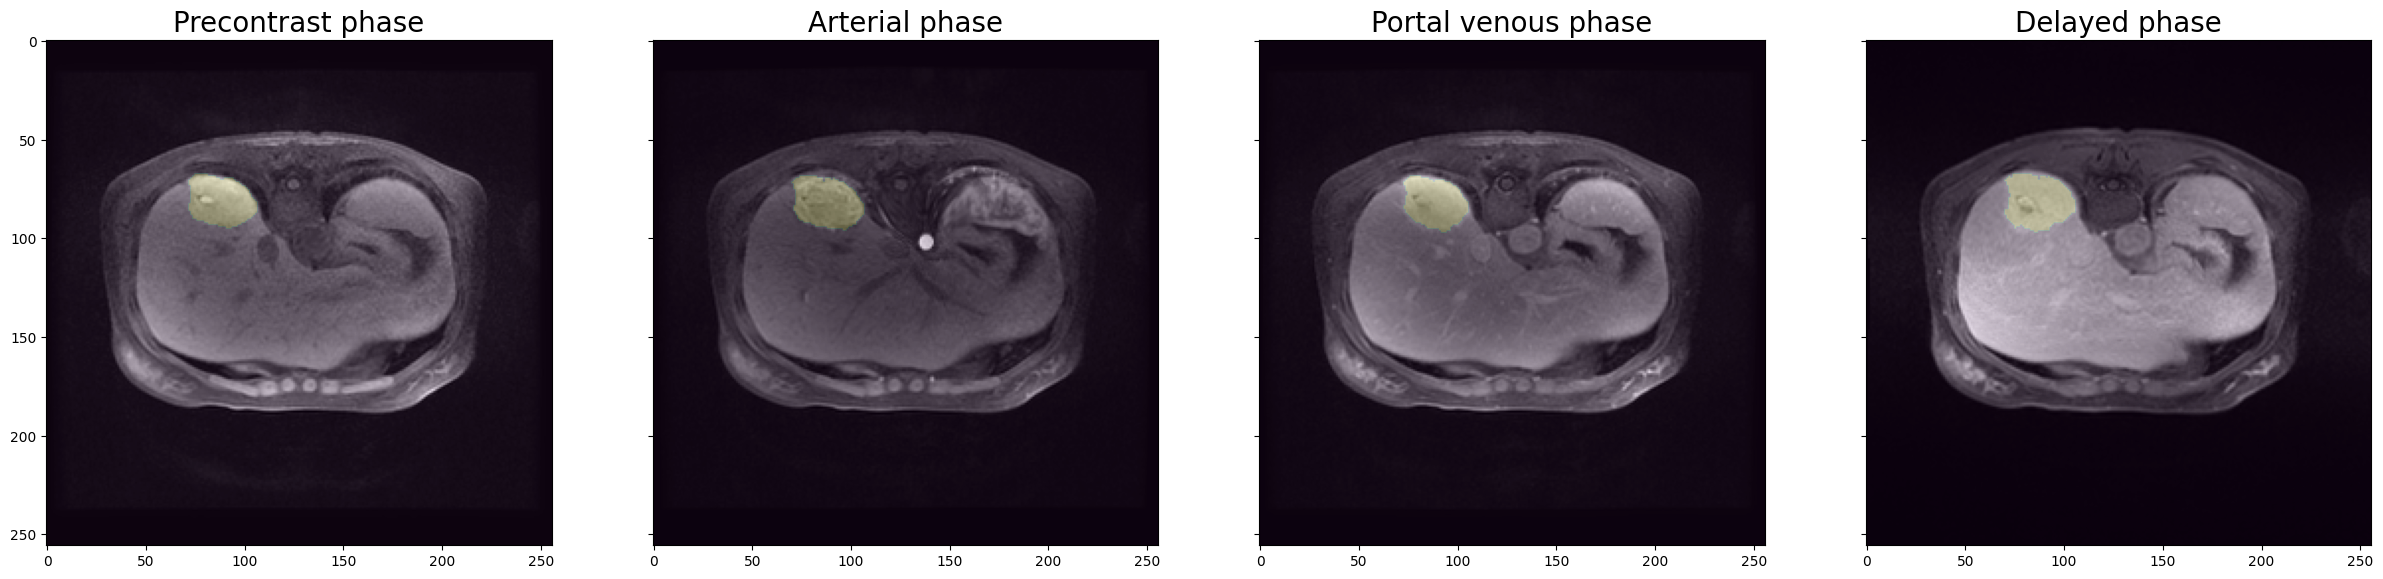

In [18]:
result_4Dimg_path = os.path.join(data_path, "result", "4D", "BLT_106.nii.gz")
result_4Dimg = itk.imread(result_4Dimg_path)
result_4Dmask_path = os.path.join(data_path, "result", "mask","4D", "BLT_106.nii.gz")
result_4Dmask = itk.imread(result_4Dmask_path)
print(result_4Dimg.shape)

# Plot images
fig, axs = plt.subplots(1,4 , sharey=True, figsize=[30,30])
plt.figsize=[50,50]
axs[0].imshow(result_4Dimg[0,73,:,:], cmap="gray")
axs[0].imshow(result_4Dmask[0,73,:,:], alpha=0.15)
axs[0].set_title('Precontrast phase', fontsize=20)
axs[1].imshow(result_4Dimg[1,73,:,:], cmap="gray")
axs[1].imshow(result_4Dmask[1,73,:,:], alpha=0.15)
axs[1].set_title('Arterial phase', fontsize=20)
axs[2].imshow(result_4Dimg[2,73,:,:], cmap="gray")
axs[2].imshow(result_4Dmask[2,73,:,:], alpha=0.15)
axs[2].set_title('Portal venous phase', fontsize=20)
axs[3].imshow(result_4Dimg[3,73,:,:], cmap="gray")
axs[3].imshow(result_4Dmask[3,73,:,:], alpha=0.15)
axs[3].set_title('Delayed phase', fontsize=20)

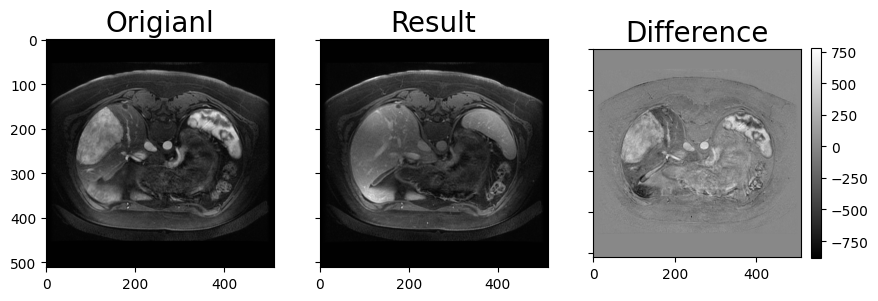

In [8]:
# origin_img_path = os.path.join(data_path, "BLT_004_0003.nii.gz")
origin_img_path = os.path.join(data_path, "result", "BLT_004_0001.nii.gz")
origin_img = itk.imread(origin_img_path)
origin_img = itk.array_from_image(origin_img)
result_img_path = os.path.join(data_path, "result", "BLT_004_0003.nii.gz")
result_img = itk.imread(result_img_path)
result_img = itk.array_from_image(result_img)

# Plot images
fig, axs = plt.subplots(1, 3, sharey=True, figsize=[10, 4])
# plt.figsize=[100,100], 
axs[0].imshow(origin_img[50,:,:], cmap="gray")
axs[0].set_title("Origianl", fontsize=20)
axs[1].imshow(result_img[50,:,:], cmap="gray")
axs[1].set_title("Result", fontsize=20)
diff_arr = origin_img[50,:,:] - result_img[50,:,:]
im = axs[2].imshow(diff_arr, cmap="gray")
axs[2].set_title("Difference", fontsize=20)

fig.colorbar(im, orientation="vertical", pad=0.04, fraction=0.046)
plt.show()

In [18]:
checkerboard(origin_img[50,:,:], result_img[50,:,:], pattern=10)